# Drug Drug Interaction 

For each entity in a sentence, see if it has interaction with another entitiy in the sentence and of which type.

## Table of contents

1. [Anonymizing the data](#1)
2. [Word embeding](#2)
3. [LSTM](#3)
4. [Make predictions](#4)

In [94]:
import sys
from os import listdir
import os

from xml.dom.minidom import parse

import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing

import gensim 
from gensim.models import Word2Vec

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Bidirectional, Dropout

print('The keras version is {}.'.format(keras.__version__))
print('The nltk version is {}.'.format(sklearn.__version__))
print('The gensim version is {}.'.format(gensim.__version__))

The keras version is 2.2.4.
The nltk version is 0.21.1.
The gensim version is 3.4.0.


In [2]:
dir_train_medline = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/MedLine/"
dir_train_drugbank = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/DrugBank/"

In [3]:
dir_test_medline = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-DDI/MedLine/"
dir_test_drugbank = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-DDI/DrugBank/"

## Anonymizing the data <a name="1"></a>

For each pair of entities in a sentence, sustitue the entity names with dummy names.

In [4]:
def get_dummy_text(txt, ents, e1, e2, error=False, debug=False):
    try:
        d = txt
        diff = 0
        for e in ents: 
            e_start = int(ents[e][0]) - diff
            e_end = int(ents[e][1]) - diff 
            e_len = e_end - e_start + 1

            if e==e1: 
                dummy = "drug01"
            elif e==e2:
                dummy = "drug02"
            else:
                dummy= "drug00"
            
            d = d[:e_start] + dummy + d[e_end+1:]
            if debug:
                print(diff, e_start, e_end, e_len)
                print(d, end = "\n\n")
            diff = diff  + (e_len - len(dummy))
        return d
    except Exception as ex:
        if error:
            print(e + ': ' + str(ex))

In [5]:
# Test the function
s_txt = "Pharmacokinetic properties of abacavir were not altered by the addition of either lamivudine or zidovudine or the combination of lamivudine and zidovudine." 
d = {'1': ['30', '37'], '2': ['82', '91'], '3': ['96', '105'], '4': ['129', '138'], '5': ['144', '153'], } 
e1 = "2"
e2 = "4"

get_dummy_text(s_txt, d, e1, e2)

'Pharmacokinetic properties of drug00 were not altered by the addition of either drug01 or drug00 or the combination of drug02 and drug00.'

In [6]:
pairs_list = []
for d in [dir_train_drugbank, dir_train_medline]:
    for f in listdir(d):
        tree = parse(d + "/" + f)
        sentences = tree.getElementsByTagName("sentence")
        for s in sentences:
            s_id = s.attributes["id"].value
            s_text = s.attributes["text"].value

            entities = {}
            ents = s.getElementsByTagName("entity")
            for e in ents:
                e_id = e.attributes["id"].value
                e_offs = e.attributes["charOffset"].value.split(";")[-1].split("-") # When two, offsets pick the second one
                entities[e_id] = e_offs

            pairs = s.getElementsByTagName("pair")
            for p in pairs:
                p_id = p.attributes["id"].value
                e1_id = p.attributes["e1"].value
                e2_id = p.attributes["e2"].value
                is_ddi = p.attributes["ddi"].value
                
                ddi = 1 if is_ddi=="true" else 0 
                ddi_type = p.attributes["type"].value if is_ddi=="true" and "type" in p.attributes else "null"
                
                s_dummy = get_dummy_text(s_text, entities, e1_id, e2_id)
                s_dummy = 'SOS '+s_dummy+ ' EOS'
                
                pair_item = {"p_id":p_id, "e1_id":e1_id, "e2_id":e2_id, "ddi":ddi, "ddi_type": ddi_type, 
                             "e1_offs":entities[e1_id], "e2_offs":entities[e2_id], "s_id":s_id, "s_text":s_text,
                             "s_dir":d, "set":d.split("/")[-2], "s_file":f,
                             "s_text_dummy": s_dummy}
                pairs_list.append(pair_item)
        
df_train = pd.DataFrame(pairs_list)

In [7]:
df_train[["ddi_type", "set"]].groupby(["set"])['ddi_type'].value_counts()

set       ddi_type 
DrugBank  null         22217
          effect        1535
          mechanism     1257
          advise         818
          int            178
MedLine   null          1555
          effect         152
          mechanism       62
          int             10
          advise           8
Name: ddi_type, dtype: int64

The parsing of the offset is not right for all elements. Some entities have an offset like [94, 97;114, 121]

In [8]:
df_train[df_train["e1_id"]=="DDI-DrugBank.d314.s30.e2"]

,ddi,ddi_type,e1_id,e1_offs,e2_id,e2_offs,p_id,s_dir,s_file,s_id,s_text,s_text_dummy,set
2317,0,null,DDI-DrugBank.d314.s30.e2,"[114, 121]",DDI-DrugBank.d314.s30.e3,"[102, 121]",DDI-DrugBank.d314.s30.p5,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Dexamethasone_ddi.xml,DDI-DrugBank.d314.s30,Vaccines: Patients on corticosteroid therapy m...,SOS drug00: Patients on drug00 therapy may exh...,DrugBank


In [9]:
df_train[df_train['s_text_dummy'].isnull()].size

0

## Word embeding <a name="2"></a>

Train a word2vec model with the data

In [10]:
df_train['tokens'] = df_train['s_text_dummy'].apply(word_tokenize)

In [11]:
data = df_train['tokens'].tolist()
len(data)

27792

In [12]:
data.append(["<UNK>"])

In [13]:
data[27792]

['<UNK>']

In [14]:
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
model1 = Word2Vec(data, min_count = 1, window=5, size = 100)

In [15]:
model1.wv["<UNK>"]

array([ 3.1045335e-03, -3.0831136e-03, -1.8168261e-03,  3.0124178e-03,
        3.0507727e-03, -1.3032128e-03,  4.6681268e-03,  3.1267668e-04,
        4.9575362e-03, -1.2362412e-03,  4.0310407e-03, -1.9815275e-03,
       -3.6951753e-03, -1.8906759e-03, -2.8895999e-03, -4.7031506e-03,
       -3.2333347e-03, -4.4047507e-03,  4.7363848e-03, -1.3500651e-03,
        3.6996533e-03, -7.4092578e-04, -2.4955223e-05,  4.6875034e-03,
       -4.3495139e-03,  4.6076286e-03, -1.6598671e-04,  1.7961287e-03,
       -1.6571211e-03,  8.7277684e-04,  3.9973161e-03, -7.5203384e-04,
       -4.2100912e-03,  2.0463571e-03,  2.8150494e-03,  5.8604468e-04,
       -4.0845545e-03, -3.7613420e-03,  3.7433105e-03, -3.5356553e-04,
       -1.0327895e-03,  2.8966737e-03, -4.6253391e-03,  2.7486794e-03,
       -2.8142082e-03, -4.5183445e-03,  5.2749476e-04,  1.8142832e-03,
       -2.1647424e-03, -2.4837621e-03, -1.0830786e-03,  1.0164224e-03,
       -1.9588579e-04, -1.7353829e-03, -9.5477246e-04,  3.6485991e-03,
      

In [16]:
df_train['tokens_enc'] = df_train['tokens'].apply(lambda x: [model1.wv[word] for word in x])

In [17]:
df_train[['tokens', 'tokens_enc']].head(2)

,tokens,tokens_enc
0,"[SOS, Milk, ,, milk, products, ,, and, drug01-...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
1,"[SOS, The, concurrent, administration, of, dru...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."


## LSTM <a name="3"></a>

Train a LSTM with the word vectors.

In [18]:
df_train.head(5)

,ddi,ddi_type,e1_id,e1_offs,e2_id,e2_offs,p_id,s_dir,s_file,s_id,s_text,s_text_dummy,set,tokens,tokens_enc
0,1,mechanism,DDI-DrugBank.d481.s0.e0,"[25, 31]",DDI-DrugBank.d481.s0.e1,"[82, 86]",DDI-DrugBank.d481.s0.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Estramustine_ddi.xml,DDI-DrugBank.d481.s0,"Milk, milk products, and calcium-rich foods or...","SOS Milk, milk products, and drug01-rich foods...",DrugBank,"[SOS, Milk, ,, milk, products, ,, and, drug01-...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
1,1,effect,DDI-DrugBank.d419.s0.e0,"[33, 43]",DDI-DrugBank.d419.s0.e1,"[49, 58]",DDI-DrugBank.d419.s0.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Clavulanate_ddi.xml,DDI-DrugBank.d419.s0,The concurrent administration of allopurinol a...,SOS The concurrent administration of drug01 an...,DrugBank,"[SOS, The, concurrent, administration, of, dru...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
2,0,null,DDI-DrugBank.d419.s0.e0,"[33, 43]",DDI-DrugBank.d419.s0.e2,"[175, 184]",DDI-DrugBank.d419.s0.p1,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Clavulanate_ddi.xml,DDI-DrugBank.d419.s0,The concurrent administration of allopurinol a...,SOS The concurrent administration of drug01 an...,DrugBank,"[SOS, The, concurrent, administration, of, dru...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
3,0,null,DDI-DrugBank.d419.s0.e1,"[49, 58]",DDI-DrugBank.d419.s0.e2,"[175, 184]",DDI-DrugBank.d419.s0.p2,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Clavulanate_ddi.xml,DDI-DrugBank.d419.s0,The concurrent administration of allopurinol a...,SOS The concurrent administration of drug00 an...,DrugBank,"[SOS, The, concurrent, administration, of, dru...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
4,1,effect,DDI-DrugBank.d419.s1.e0,"[45, 54]",DDI-DrugBank.d419.s1.e1,"[73, 83]",DDI-DrugBank.d419.s1.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Clavulanate_ddi.xml,DDI-DrugBank.d419.s1,It is not known whether this potentiation of a...,SOS It is not known whether this potentiation ...,DrugBank,"[SOS, It, is, not, known, whether, this, poten...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."


In [19]:
Ys = df_train['ddi_type']
Ys.shape

(27792,)

In [20]:
le = preprocessing.LabelEncoder()
le.fit(Ys)
print("Classes:",le.classes_)

Classes: ['advise' 'effect' 'int' 'mechanism' 'null']


In [21]:
df_train['ddi_type_enc'] = df_train['ddi_type'].apply(lambda x: le.transform([x]) )

In [22]:
df_train.head(1)

,ddi,ddi_type,e1_id,e1_offs,e2_id,e2_offs,p_id,s_dir,s_file,s_id,s_text,s_text_dummy,set,tokens,tokens_enc,ddi_type_enc
0,1,mechanism,DDI-DrugBank.d481.s0.e0,"[25, 31]",DDI-DrugBank.d481.s0.e1,"[82, 86]",DDI-DrugBank.d481.s0.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Estramustine_ddi.xml,DDI-DrugBank.d481.s0,"Milk, milk products, and calcium-rich foods or...","SOS Milk, milk products, and drug01-rich foods...",DrugBank,"[SOS, Milk, ,, milk, products, ,, and, drug01-...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011...",[3]


In [23]:
Xs_enc = np.array(df_train['tokens_enc'].tolist())
Ys_enc = np.array(df_train['ddi_type_enc'].tolist())
print(Xs_enc.shape, Ys_enc.shape)

(27792,) (27792, 1)


In [24]:
# Xs_enc = [sentence1 , sentence2, ...]
# Xs_enc[i] = [word1, word2, ...]
# Xs_enc[i][j] = [vector]
# Xs_enc = [[[vector], [vector], ...] , [[vector], [vector], ...], ...]
# reshape input to be [sentence, words, features]
print(len(Xs_enc), len(Xs_enc[0]), len(Xs_enc[0][0]))

27792 19 100


In [25]:
sentence_len = [len(x) for x in Xs_enc]
print("Max:", max(sentence_len), "Min:", min(sentence_len), "Mean", np.mean(sentence_len))

Max: 152 Min: 3 Mean 54.08822682786413


In [26]:
trainX = np.zeros([27792, 152, 100])

for i, s in enumerate(Xs_enc):
    s = np.array(s)
    shape = s.shape
    for j in range(shape[0], 152):
        s = np.append(s, np.zeros([1,100]), axis=0)
    trainX[i] = s
    
print( type(trainX), trainX.shape)

<class 'numpy.ndarray'> (27792, 152, 100)


In [27]:
enc = preprocessing.OneHotEncoder(sparse=False)
enc.fit(Ys_enc)
print("Categories: ",enc.categories_)

Categories:  [array([0., 1., 2., 3., 4.])]


/Users/lluccardoner/anaconda3/envs/AHLT-LSTM/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [28]:
enc.transform(np.array([0]).reshape((1, -1)))
enc.transform(np.array([1]).reshape((1, -1)))
enc.transform(np.array([2]).reshape((1, -1)))
enc.transform(np.array([3]).reshape((1, -1)))
enc.transform(np.array([4]).reshape((1, -1)))

array([[0., 0., 0., 0., 1.]])

In [29]:
trainY = np.zeros([27792, 5]) #5 classes

for i, l in enumerate(Ys_enc):
    l_enc = enc.transform(l.reshape(1, -1))
    trainY[i] = np.array(l_enc)
    
print(type(trainY), trainY.shape)

<class 'numpy.ndarray'> (27792, 5)


In [125]:
model = Sequential()
model.add(Bidirectional(LSTM(60, input_shape=(152, 100))))
model.add(Dropout(rate=0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
history = model.fit(trainX, trainY, validation_split=0.20, epochs=10, batch_size=100, verbose=1)

Train on 22233 samples, validate on 5559 samples
Epoch 1/10
22233/22233 [==============================] - 203s 9ms/step - loss: 0.5434 - acc: 0.8499 - val_loss: 0.4635 - val_acc: 0.8536
Epoch 2/10
22233/22233 [==============================] - 193s 9ms/step - loss: 0.3206 - acc: 0.8883 - val_loss: 0.4189 - val_acc: 0.8608
Epoch 3/10
22233/22233 [==============================] - 199s 9ms/step - loss: 0.2435 - acc: 0.9149 - val_loss: 0.4189 - val_acc: 0.8726
Epoch 4/10
22233/22233 [==============================] - 201s 9ms/step - loss: 0.2030 - acc: 0.9297 - val_loss: 0.3976 - val_acc: 0.8681
Epoch 5/10
22233/22233 [==============================] - 184s 8ms/step - loss: 0.1788 - acc: 0.9396 - val_loss: 0.4037 - val_acc: 0.8581
Epoch 6/10
22233/22233 [==============================] - 188s 8ms/step - loss: 0.1572 - acc: 0.9478 - val_loss: 0.4003 - val_acc: 0.8734
Epoch 7/10
22233/22233 [==============================] - 178s 8ms/step - loss: 0.1404 - acc: 0.9545 - val_loss: 0.4158 - v

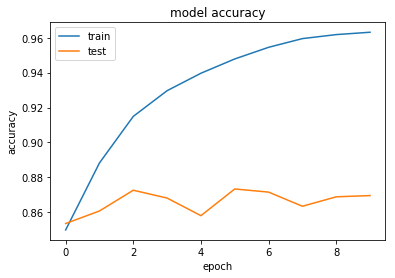

In [127]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

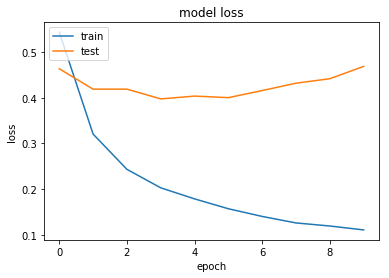

In [128]:
# summarize history for loss
plt.plot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Make predictions <a name="4"></a>

In [110]:
test_dfs={}
for d in [dir_test_drugbank, dir_test_medline]:
    pairs_list = []
    for f in listdir(d):
        tree = parse(d + "/" + f)
        sentences = tree.getElementsByTagName("sentence")
        for s in sentences:
            s_id = s.attributes["id"].value
            s_text = s.attributes["text"].value

            entities = {}
            ents = s.getElementsByTagName("entity")
            for e in ents:
                e_id = e.attributes["id"].value
                e_offs = e.attributes["charOffset"].value.split(";")[-1].split("-") # When two, offsets pick the second one
                entities[e_id] = e_offs

            pairs = s.getElementsByTagName("pair")
            for p in pairs:
                p_id = p.attributes["id"].value
                e1_id = p.attributes["e1"].value
                e2_id = p.attributes["e2"].value
                is_ddi = p.attributes["ddi"].value
                
                ddi = 1 if is_ddi=="true" else 0 
                ddi_type = p.attributes["type"].value if is_ddi=="true" and "type" in p.attributes else "none"
                
                s_dummy = 'SOS '+s_text+ ' EOS'
                
                pair_item = {"p_id":p_id, "e1_id":e1_id, "e2_id":e2_id, "ddi":ddi, "ddi_type": ddi_type, 
                             "e1_offs":entities[e1_id], "e2_offs":entities[e2_id], "s_id":s_id, "s_text":s_text,
                             "s_dir":d, "set":d.split("/")[-2], "s_file":f, "s_text_dummy": s_dummy}
                pairs_list.append(pair_item)
    test_dfs[d] = pairs_list
    
df_test_medline = pd.DataFrame(test_dfs[dir_test_medline])
df_test_drugbank = pd.DataFrame(test_dfs[dir_test_drugbank])

In [111]:
df_test_medline['tokens'] = df_test_medline['s_text_dummy'].apply(word_tokenize)
df_test_drugbank['tokens'] = df_test_drugbank['s_text_dummy'].apply(word_tokenize)

In [112]:
df_test_medline['tokens_enc'] = df_test_medline['tokens'].apply(lambda x: [model1.wv[word] if word in model1.wv.vocab else model1.wv['<UNK>'] for word in x])
df_test_drugbank['tokens_enc'] = df_test_drugbank['tokens'].apply(lambda x: [model1.wv[word] if word in model1.wv.vocab else model1.wv['<UNK>'] for word in x])

In [113]:
df_test_medline.head()

,ddi,ddi_type,e1_id,e1_offs,e2_id,e2_offs,p_id,s_dir,s_file,s_id,s_text,s_text_dummy,set,tokens,tokens_enc
0,0,none,DDI-MedLine.d180.s1.e0,"[4, 22]",DDI-MedLine.d180.s1.e1,"[25, 29]",DDI-MedLine.d180.s1.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,21720561.xml,DDI-MedLine.d180.s1,"The 3-Deazaneplanocin A (DZNep), one of S-aden...","SOS The 3-Deazaneplanocin A (DZNep), one of S-...",MedLine,"[SOS, The, 3-Deazaneplanocin, A, (, DZNep, ), ...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
1,0,none,DDI-MedLine.d180.s10.e0,"[46, 50]",DDI-MedLine.d180.s10.e1,"[92, 96]",DDI-MedLine.d180.s10.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,21720561.xml,DDI-MedLine.d180.s10,We also found that Bcl-2 was overexpressed in ...,SOS We also found that Bcl-2 was overexpressed...,MedLine,"[SOS, We, also, found, that, Bcl-2, was, overe...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
2,0,none,DDI-MedLine.d180.s10.e0,"[46, 50]",DDI-MedLine.d180.s10.e2,"[102, 108]",DDI-MedLine.d180.s10.p1,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,21720561.xml,DDI-MedLine.d180.s10,We also found that Bcl-2 was overexpressed in ...,SOS We also found that Bcl-2 was overexpressed...,MedLine,"[SOS, We, also, found, that, Bcl-2, was, overe...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
3,0,none,DDI-MedLine.d180.s10.e0,"[46, 50]",DDI-MedLine.d180.s10.e3,"[195, 199]",DDI-MedLine.d180.s10.p2,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,21720561.xml,DDI-MedLine.d180.s10,We also found that Bcl-2 was overexpressed in ...,SOS We also found that Bcl-2 was overexpressed...,MedLine,"[SOS, We, also, found, that, Bcl-2, was, overe...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
4,1,effect,DDI-MedLine.d180.s10.e1,"[92, 96]",DDI-MedLine.d180.s10.e2,"[102, 108]",DDI-MedLine.d180.s10.p3,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,21720561.xml,DDI-MedLine.d180.s10,We also found that Bcl-2 was overexpressed in ...,SOS We also found that Bcl-2 was overexpressed...,MedLine,"[SOS, We, also, found, that, Bcl-2, was, overe...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."


In [114]:
df_test_drugbank.head()

,ddi,ddi_type,e1_id,e1_offs,e2_id,e2_offs,p_id,s_dir,s_file,s_id,s_text,s_text_dummy,set,tokens,tokens_enc
0,1,mechanism,DDI-DrugBank.d765.s0.e0,"[19, 30]",DDI-DrugBank.d765.s0.e1,"[135, 145]",DDI-DrugBank.d765.s0.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Tolterodine.xml,DDI-DrugBank.d765.s0,"CYP3A4 Inhibitors: Ketoconazole, an inhibitor ...","SOS CYP3A4 Inhibitors: Ketoconazole, an inhibi...",DrugBank,"[SOS, CYP3A4, Inhibitors, :, Ketoconazole, ,, ...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
1,0,none,DDI-DrugBank.d765.s1.e0,"[23, 34]",DDI-DrugBank.d765.s1.e1,"[84, 100]",DDI-DrugBank.d765.s1.p0,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Tolterodine.xml,DDI-DrugBank.d765.s1,For patients receiving ketoconazole or other p...,SOS For patients receiving ketoconazole or oth...,DrugBank,"[SOS, For, patients, receiving, ketoconazole, ...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
2,0,none,DDI-DrugBank.d765.s1.e0,"[23, 34]",DDI-DrugBank.d765.s1.e2,"[107, 118]",DDI-DrugBank.d765.s1.p1,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Tolterodine.xml,DDI-DrugBank.d765.s1,For patients receiving ketoconazole or other p...,SOS For patients receiving ketoconazole or oth...,DrugBank,"[SOS, For, patients, receiving, ketoconazole, ...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
3,0,none,DDI-DrugBank.d765.s1.e0,"[23, 34]",DDI-DrugBank.d765.s1.e3,"[121, 130]",DDI-DrugBank.d765.s1.p2,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Tolterodine.xml,DDI-DrugBank.d765.s1,For patients receiving ketoconazole or other p...,SOS For patients receiving ketoconazole or oth...,DrugBank,"[SOS, For, patients, receiving, ketoconazole, ...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."
4,0,none,DDI-DrugBank.d765.s1.e0,"[23, 34]",DDI-DrugBank.d765.s1.e4,"[136, 156]",DDI-DrugBank.d765.s1.p3,/Users/lluccardoner/PycharmProjects/MET_AHLT_L...,Tolterodine.xml,DDI-DrugBank.d765.s1,For patients receiving ketoconazole or other p...,SOS For patients receiving ketoconazole or oth...,DrugBank,"[SOS, For, patients, receiving, ketoconazole, ...","[[0.5819571, 0.9497496, -1.6383795, -1.5564011..."


In [115]:
Xs_enc_medline = np.array(df_test_medline['tokens_enc'].tolist())
Xs_enc_drugbank = np.array(df_test_drugbank['tokens_enc'].tolist())

In [116]:
print("Medline ", len(Xs_enc_medline), len(Xs_enc_medline[0]), len(Xs_enc_medline[0][0]))
print("Drugbank ", len(Xs_enc_drugbank), len(Xs_enc_drugbank[0]), len(Xs_enc_drugbank[0][0]))

Medline  451 34 100
Drugbank  5265 43 100


In [117]:
sentence_len_medline = [len(x) for x in Xs_enc_medline]
sentence_len_drugbank = [len(x) for x in Xs_enc_drugbank]

print("Medline ", "Max:", max(sentence_len_medline), "Min:", min(sentence_len_medline), "Mean", np.mean(sentence_len_medline))
print("Drugbank ", "Max:", max(sentence_len_drugbank), "Min:", min(sentence_len_drugbank), "Mean", np.mean(sentence_len_drugbank))

Medline  Max: 71 Min: 6 Mean 32.83592017738359
Drugbank  Max: 109 Min: 9 Mean 48.27350427350427


In [122]:
def lstm_predictions(data_df, text_file):
    for index, row in data_df.iterrows():
        id_sen = row['s_id']
        id_drug1 = row['e1_id']
        id_drug2 = row['e2_id']

        predictX = np.zeros([1, 152, 100])
        sentence = row['tokens_enc']
        s= np.array(sentence)
        shape = s.shape
        for j in range(shape[0], 152):
            s = np.append(s, np.zeros([1,100]), axis=0)
        predictX[0] = s

        pred = model.predict(predictX)

        t_pred = np.argmax(pred)
        
        pred_type = le.inverse_transform(np.array(t_pred).reshape(1,-1))[0]

        DDI = 0
        if t_pred != 4:
            DDI = 1

        # idSentence|iddrug1|iddrug2|prediction|type
        print(id_sen, id_drug1, id_drug2, DDI, pred_type, sep="|", file=text_file)

In [123]:
def save_output(data_df, file_name):
    with open(file_name, "w") as text_file:
        lstm_predictions(data_df, text_file)

In [124]:
lstm_predictions(df_test_medline, None)
lstm_predictions(df_test_drugbank, None)

DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e0|DDI-DrugBank.d775.s11.e1|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e0|DDI-DrugBank.d775.s11.e2|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e0|DDI-DrugBank.d775.s11.e3|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e0|DDI-DrugBank.d775.s11.e4|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e0|DDI-DrugBank.d775.s11.e5|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e0|DDI-DrugBank.d775.s11.e6|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e1|DDI-DrugBank.d775.s11.e2|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e1|DDI-DrugBank.d775.s11.e3|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e1|DDI-DrugBank.d775.s11.e4|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e1|DDI-DrugBank.d775.s11.e5|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e1|DDI-DrugBank.d775.s11.e6|0|effect
DDI-DrugBank.d775.s11|DDI-DrugBank.d775.s11.e2|DDI-DrugBank.d775.s11.e3|0|effect
DDI-DrugBank.d775.s11|DDI-Dr

In [44]:
save_output(df_test_medline, "task9.2_LSTM_medline.txt")
save_output(df_test_drugbank, "task9.2_LSTM_drugbank.txt")

/Users/lluccardoner/anaconda3/envs/AHLT-LSTM/lib/python3.6/site-packages/sklearn/preprocessing/label.py:273: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
